# Empirical coverage test

In [1]:
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as  pl
import gc
import pdb
import scipy.optimize as op
import scipy.special as spsp
from getdist.paramnames import escapeLatex, makeList, mergeRenames

import os

def get_max_2dpost(g, root, param1='cosmological_parameters--omega_m', param2='cosmological_parameters--s8',param_pair = None):
    param_pair = g.get_param_array(root, param_pair or [param1, param2])
    
    density = g.sample_analyser.get_density_grid(root, param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)
    xyind = np.where(density.P == np.amax(density.P))
    return density.y[xyind[0][0]],density.x[xyind[1][0]]
    
# ok -------------
def get_contour_line(sigma_contour,g, density):

    contours = spsp.erf(sigma_contour/np.sqrt(2))
    density.contours = density.getContourLevels([contours])
    contour_levels = density.contours
    fig1, ax1 = pl.subplots(1)
    cs = pl.contour(density.x, density.y, density.P, sorted(contour_levels))
    lines = []
    for line in cs.collections[0].get_paths():
        lines.append(line.vertices)
    pl.close()
    return lines

def get_dmin(line, xref, yref):
    linex = line[0][:,0]
    liney = line[0][:,1]
    d_all = np.sqrt((linex - xref)**2 + (liney - yref)**2)
    dmin = np.amin(d_all)
    return dmin

# ok ======
def lefthand(sigma_contour, g, density, xref, yref): 
    line = get_contour_line(sigma_contour,g, density)
    result = get_dmin(line, xref, yref)  
    return result

def diff(sigma_contour, g, density, xref, yref):
    result = lefthand(sigma_contour, g, density, xref, yref)
    return result

def root_find(init_x,g, density, xref, yref): 
    nll = lambda *args: diff(*args)
    args = (g, density, xref, yref)
    result = op.root(nll,np.array([init_x]),args=args,options={'maxfev':50})
    return result

# ok------
def min_find(init_x,g, density, xref, yref): 
    nll = lambda *args: diff(*args)
    args = (g, density, xref, yref)
    result = op.fmin(nll,np.array([init_x]),args=args)
    return result#-0.003





def do_scale_cut(chain1,p1='$\Omega_m$',p2='$S_8$',param1_truth=0.3,param2_truth=0.8):
    from getdist.paramnames import escapeLatex, makeList, mergeRenames

    su = [chain1]
    param1 = p1
    param2 = p2

    xlab= p1
    ylab = p2

    Samples = su
    roots = makeList(Samples)
    
    g = plots.getSinglePlotter(ratio = 5./3., width_inch= 5. )


    param2_base, param1_base = get_max_2dpost(g, roots[0],param1=param1, param2=param2)

    param_pair = g.get_param_array(roots[0], None or [param1, param2])
    density = g.sample_analyser.get_density_grid(roots[0], param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)


    # Get the 2D distance in terms of sigma. In case you get some weird getdist error, change the starting guess value (here 0.01)
    res_truth_base = min_find(0.01,g, density, param1_truth, param2_truth)

    del g
    gc.collect()
    pl.close()
    return res_truth_base
     

In [2]:
# load Shub's files --------------------------------------
import numpy as np
import frogress
base = '/pscratch/sd/m/mgatti/files_Shub/'
VIT_half = np.load(base+'20230725_vit_DES_half_sky.npz')
VIT_des = np.load(base+'20230725_vit_DES.npz')
RESNET_half = np.load(base+'20230728_resnet_DES_half_sky.npz')
RESNET_des = np.load(base+'20230728_resnet_DES.npz')




In [30]:
# let's focus on the first two parameters ------------------
p1 = 0
p2 = 1


samples = dict()
samples['VIT_half'] = VIT_half 
samples['VIT_des'] = VIT_des 
samples['RESNET_half'] = RESNET_half
samples['RESNET_des'] = RESNET_des 
conts = dict()
for k in samples.keys():
    cont = []
    for i in frogress.bar(range(200)):
        if not os.path.exists('./temp/{0}_{1}.npy'.format(k,i)):
            try:
                samples1 = MCSamples(samples=[samples[k]['chains'][i,:,p1],samples[k]['chains'][i,:,p2]],
                                                        names = ['om','s8'],
                settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})
                            #
                '''
                g = plots.getSubplotPlotter(width_inch=5.5)
                g.settings.axis_marker_color  = 'black'
                g.triangle_plot([samples1])
                plt.show()
                '''
                a = do_scale_cut(samples1,'om','s8',param1_truth=samples[k]['labels'][i,p1],param2_truth=samples[k]['labels'][i,p2])
                cont.append(a[0])

                np.save('./temp/{0}_{1}'.format(k,i),a[0])
                #np.save(folder+'{0}_{1}'.format(k,ii),[a,om,s8])
                del samples1
                gc.collect()
            except:
                print ('failed ',k,i) 
                cont.append(np.abs(np.random.normal(0,1,1)))
        else:
            a = np.load('./temp/{0}_{1}.npy'.format(k,i),allow_pickle=True)
            cont.append(a)
        #conts[k] = np.array(cont)
        #conts1[k] = np.array(cont1)
    conts[k] = np.array(cont)
np.save('./conts_shub',conts)

  0.5% | [..........] | Progress: 1 / 200 | Time: 0.0s | ETA: 0.0sRemoved no burn in
failed  RESNET_des 26
100.0% | [##########] | Progress: 200 / 200 | Time: 0.3s | ETA: --s

/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<Figure size 360x600 with 0 Axes>

In [83]:
import numpy as np
conts = np.load('conts_shub.npy',allow_pickle=True).item()

dict_keys(['VIT_half', 'VIT_des', 'RESNET_half', 'RESNET_des'])

In [97]:
import numpy as np

steps = 50
cum = np.zeros(steps)
ref = np.linspace(0,3,steps)
# Generate a random sample of data with mean=0 and standard deviation=1
data = np.random.normal(0, 1, 1000000)
data11 = np.random.normal(0, 1.2, 1000000)
data09 = np.random.normal(0, 0.8, 1000000)
f = []
f11 = []
f09 = []

# Calculate the percentage of data within X standard deviations from the mean for a few cases
for r in ref:
    within_one_sigma = len(data[abs(data)<r])/len(data)
    f.append(within_one_sigma)
f = np.array(f)

for r in ref:
    within_one_sigma = len(data[abs(data09)<r])/len(data)
    f09.append(within_one_sigma)
f09 = np.array(f09)

for r in ref:
    within_one_sigma = len(data[abs(data11)<r])/len(data)
    f11.append(within_one_sigma)
f11 = np.array(f11)

In [99]:
# generate testss

cont_ = []
for i in range(1000):
    cont = []
    for i in range(200):
        cont.append(np.abs(np.random.normal(0,1,1)))
    cont = np.array(cont)
    cum = np.zeros(steps)
    for i,xx in enumerate(ref):
        cum[i] = 1.*len(cont[cont<xx])/len(cont)
    cont_.append(cum)
cont_ = np.array(cont_)


def compute_two_tail_percentile(data, x):
    lower_percentile = (100 - x) / 2
    upper_percentile = 100 - lower_percentile
    
    lower_threshold = np.percentile(data, lower_percentile)
    upper_threshold = np.percentile(data, upper_percentile)
    
    return lower_threshold, upper_threshold

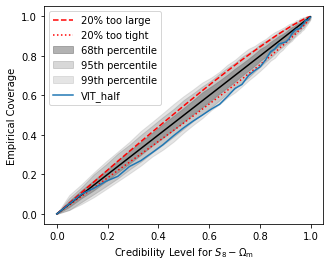

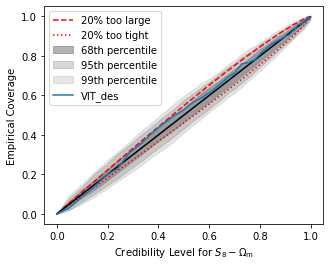

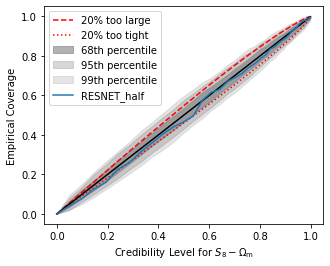

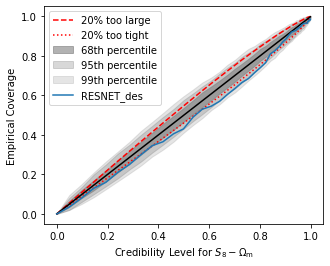

In [100]:
cumk = dict()
for k in conts.keys():
    cum = np.zeros(steps)
    for i,xx in enumerate(ref):
        cum[i] = 1.*len(conts[k][conts[k]<xx])/len(conts[k])
    cumk[k] = cum
    
    
import matplotlib.pyplot as plt
for k in cumk.keys():
    fig, ax = plt.subplots(1,1,figsize = (5,4),sharex = True)

    plt.errorbar(f,cumk[k], label = k)
    plt.plot(f,f09,color='red', linestyle = 'dashed',label = '20% too large')
    plt.plot(f,f11,color='red', linestyle = 'dotted',label = '20% too tight')
    plt.plot(f,f,color='black')
    plt.ylabel('Empirical Coverage')
    plt.xlabel(r'Credibility Level for $S_8-\Omega_{\rm m}$')

    
    #ax[0].show()

    up_68 = []
    low_68 = []
    for i in range(cont_.shape[1]):
        a,b = compute_two_tail_percentile(cont_[:,i], 68)
        up_68.append(a)
        low_68.append(b)
    plt.fill_between(f,low_68,up_68,color='grey',alpha = 0.6,label = '68th percentile')
    up_68 = []
    low_68 = []
    for i in range(cont_.shape[1]):
        a,b = compute_two_tail_percentile(cont_[:,i], 95)
        up_68.append(a)
        low_68.append(b)
    plt.fill_between(f,low_68,up_68,color='grey',alpha = 0.3,label = '95th percentile')
    
    
    up_68 = []
    low_68 = []
    for i in range(cont_.shape[1]):
        a,b = compute_two_tail_percentile(cont_[:,i], 99)
        up_68.append(a)
        low_68.append(b)
    plt.fill_between(f,low_68,up_68,color='grey',alpha = 0.2,label = '99th percentile')
   
    plt.legend()
    plt.show()